# Modeling axial dispersion

## Solve_bvp

Until now we have looked at plug-flow reactors where we have assumed the 2nd order axial dispersion term to be constant. But what if we want to model axial dispersion? Axial dispersion can be very significant for instance in laboratory reactors where the reactor lenght is short in comparison to the size of a catalyst particle, or if we have laminar flow. Luckily, Scipy (and other scientific computing packages) has a solver that can do exactly this. It is called solve_bvp. But before we can use it, we have to manipulate our equation a bit.

To make things more simple, let's assume 1st order chemical reaction so that $S = -kC$. Let's also assume constant temperature. In order to us
First we have to rewrite the second order ODE as a system of first order ODEs. This is done by introducing a new variable $\frac{dC}{dz}=C'$. Then we can rewrite the system as
\begin{align}
\frac{dC}{dz} &= C'\\
\frac{dC'}{dz} &= \frac{uC'}{D}-\frac{S}{D}
\end{align}
Let's write $Y_1$ for $C$ and $Y_2$ for $C'$:
\begin{align}
Y_1' &= Y_2\\
Y_2' &= \frac{uY_2}{D}-\frac{S}{D}
\end{align}
With a second order differential equation, it is not enough to specify the inlet concentrations as we did for the plug flow model. Instead we need to specify the boundary conditions at both boundaries. In practice, this can be a huge problem since in many cases the outlet boundary condition is not known. In chemical engineering, the Danckwerts boundary conditions are widely used.
\begin{align}
Y_1\left(0\right) &= Y_0 + \frac{D}{u}Y_2\\
Y_2\left(L\right) &= 0
\end{align}
Now let's think for a moment what this means. The second boundary condition is easy. It says that the 2nd derivative of the concentration profile is 0 at the exit of the reactor tube. Thus there is also no diffusion or axial dispersion at the outlet. And the first condition? It actually says that there is a discontinuity in the concentration profile at the reactor tube inlet. This means that concentration drops instantly.

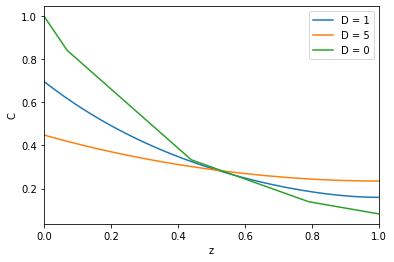

In [18]:
# import the solve_bvp package
from scipy.integrate import solve_bvp
from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt

# define the plug-flow reactor model with axial dispersion
# note that this time, we have to use numpy arrays instead of lists
def pfr_disp(z, C): 
    u = 4.
    k = 10.    
    return np.vstack((C[1], u*C[1]/D + k*C[0]/D))

# define the function that calculates the residuals of the boundary conditions
def pfr_bc(Ca, Cb):
    u = 4.
    C0 = 1.
    return np.array([C0 - Ca[0] + D/u * Ca[1], Cb[1]])

# let's calculate the value of the function at ten point between 0 and 1
x = np.linspace(0, 1, 100)

# we need to define the initial values for the whole domain
C_init = np.zeros((2, x.size))

# now the model can be solved
D = 1.
res = solve_bvp(pfr_disp, pfr_bc, x, C_init)

# for comparison, let's also solve this problem with a different value for the axial dispersion coefficient.
D = 5.
res_2 = solve_bvp(pfr_disp, pfr_bc, x, C_init)

# and finally for comparison, let's solve as plug-flow reactor (D = 0)
def pfr_plug(z, C):
    u = 4.
    k = 10.
    return -k * C / u

res_comp = solve_ivp(pfr_plug, (0., 1.), [1.])

plt.plot(res.x, res.y[0,:])
plt.plot(res_2.x, res_2.y[0,:])
plt.plot(res_comp.t, res_comp.y[0,:])
plt.xlim((0., 1.0))
plt.xlabel("z")
plt.ylabel("C")
plt.legend(["D = 1", "D = 5", "D = 0"])
plt.show()

Here we can observe how with increasing Dispersion coefficient D the concentration profile becomes more flat and also conversion of becomes less. Actually we can see that the two ideal reactors Plug flow reactor on the one hand and CSTR on the other hand are the limiting cases of the general reactor model with axial dispersion, for D = 0 and D = infinity, respectively.
While this model can be solved with the solve_bvp solver, we see that it is not optimal for this kind of problem. First, we would like to get the plug-flow reactor solution when we substitute $D = 0$. But instead, we get a division by zero error.

In [19]:
D = 0.
res = solve_bvp(pfr_disp, pfr_bc, x, C_init)

C:\Users\cheme\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
C:\Users\cheme\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':


This is because the CSTR cannot be described with a differential equation; the equation for a CSTR is an algebraic equation since the concentration is assumed constant throughout the reactor:

\begin{equation}
C_{out} = C_{in} - \frac{Vr}{Q}
\end{equation}

## Solution with finite differences

As you could see in the previous paragraph, solving a reactor model with axial dispersion using solve_bvp is possible but it can be a little cumbersome. There are other numerical methods that can be employed. The first and obvious one is discretization. This approach is known as the Finite Difference Method. 

The idea behind finite differences can be seen immediately in the definition of a derivative:

\begin{equation}
\frac{d\Psi}{dx} = lim \frac{\Psi(x+\Delta x)-\Psi (x)}{\Delta x}
\end{equation}

Using this definition, three approximations of the first spatial derivative that use neighboring points can be derived instantly. They are:

Forward difference
\begin{equation}
\frac{d\Psi}{dx} \approx \frac{\Psi_{i+1}-\Psi_i}{\Delta x}
\end{equation}
Backward difference or first order upwind
\begin{equation}
\frac{d\Psi}{dx} \approx \frac{\Psi_i-\Psi_{i-1}}{\Delta x}
\end{equation}
Central difference
\begin{equation}
\frac{d\Psi}{dx} \approx \frac{\Psi_{i+1}-\Psi_{i-1}}{2\Delta x}
\end{equation}
2nd derivatives can be approximated with:
\begin{equation}
\frac{d^2 \Psi}{dx^2} \approx \frac{\Psi_{i+1} - 2 \Psi_i + \Psi_{i-1}}{\Delta x^2}
\end{equation}

Higher-order schemes, both symmetric and asymmetric, can be derived easily from Taylor series expansions. The sum of the terms in the Taylor series that is dropped from the dischret representation of the derivative is called truncation error. The highest power of $\frac{d\Psi}{dz}$ that is retained is called method order.

The forward and backward difference schemes are both first-order accurate. The central difference and other three point schemes are second order accurate (the point in the center cancels out in the equation). There are also schemes that use all the points in a domain. Those are called Spectral Methods and they are particularly useful in domains with periodic boundary conditions.

The choice of the differencing scheme for the advection term inluences directly the numerical behavior of the system. First-order schemes suffer from heavy numerical diffusion, whereas higher-order schemes suffer from spurious oscillations in the vicinity of steep gradients.

Another often used discretization scheme is the second order upwind scheme:
\begin{equation}
\frac{d\Psi}{dx} \approx \frac{3\Psi_{i}-4\Psi_{i-1}+\Psi_{i-2}}{2\Delta x}
\end{equation}

A major advantage of the finite difference method is that it can be written down in compact matrix notation. The discretized variable $\Psi$ is written in the vector $\vec{\Psi}$. The scheme can be represented with matrix $\mathbf{A}$. So the vector $\vec{\frac{d\Psi}{dx}}$ can be written as:

\begin{equation}
\vec{\frac{d\Psi}{dx}} = \mathbf{A}\vec{\Psi}
\end{equation}

For a central difference for example, matrix A becomes:
\begin{equation*}
\mathbf{A} =  \frac{1}{2\Delta x}\begin{vmatrix}
-1 & 0 & 1 & 0 & 0 & ... \\
0 & -1 & 0 & 1 & 0 & ... \\
0 & 0 & -1 & 0 & 1 & ... \\
... 
\end{vmatrix}
\end{equation*}

For the second derivative with central difference we define matrix B:
\begin{equation*}
\mathbf{B} =  \frac{1}{\Delta x^2}\begin{vmatrix}
1 & -2 & 1 & 0 & 0 & ... \\
0 & 1 & -2 & 1 & 0 & ... \\
0 & 0 & 1 & -2 & 1 & ... \\
... 
\end{vmatrix}
\end{equation*}

So then the steady-state convection dispersion equation can be written as:
\begin{equation*}
0 = \left(-\frac{u}{2\Delta x}\mathbf{A} + \frac{D}{\Delta x^2} \mathbf{B} \right) \vec{\Psi} + \vec{S}
\end{equation*}

This is an equation that can be solved (in the general case) with a nonlinear solver or with a linear solver if the source term itself is linear.

But what about boundary conditions? Those are actually way easier to handle than you would think. Let's recall the Danckwerts boundary condition for the inlet:

\begin{equation*}
\Psi_{init} = \Psi(z = 0) - \frac{D}{u}\frac{d\Psi}{dz}\left(z = 0\right)
\end{equation*}

Let's assume that there is one more "imaginary" grid point outside of the domain. Then let's look at the point at the inlet and insert the difference approximation for the derivative:

\begin{equation}
\Psi_{init} = \Psi_0 - \frac{D}{u}\frac{\Psi_{+1}-\Psi_{-1}}{2\Delta x}
\end{equation}

Then we can rearrange and solve for the "imaginary" grid point $\Psi_{-1}$:

\begin{equation}
\Psi_{-1} = \Psi_{+1} + \frac{2dxu}{D}(\Psi_{init} - \Psi_0)
\end{equation}

If we use the 1st order upwind approximation then we get

\begin{equation}
\Psi_{-1} = \Psi_{0} + \frac{2dxu}{D}(\Psi_{init} - \Psi_0)
\end{equation}

In [2]:
# Let's try in Python
import numpy as np

points = 100

# This function constructs the convection matrix for central difference
def construct_conv_matrix_central_diff(points):
    before = 1
    after = 1
    A = np.zeros(shape = (points, points+before+after))
    a = -0.5
    b = 0.
    c = 0.5

    for i in range(points):
        for j in range(points+before+after):
            if i + before == j:
                A[i,j] = b
                if j + 1 < points + before + after:
                    A[i,j+1] = c
                if j - 1 >= 0 :
                    A[i,j-1] = a
    return A

# This function constructs the convection matrix for 1st order upwind
def construct_conv_matrix_upwind(points):
    before = 1
    after = 1
    A = np.zeros(shape = (points, points + before + after))
    a = -1.
    b = 1.
    c = 0.

    for i in range(points):
        for j in range(points + before + after):
            if i + before == j:
                A[i,j] = b
                if j + 1 < points + before + after:
                    A[i,j+1] = c
                if j - 1 >= 0 :
                    A[i,j-1] = a
    return A

A = construct_conv_matrix_central_diff(points)
A_2 = construct_conv_matrix_upwind(points)

print(A)
print(A_2)

[[-0.5  0.   0.5 ...  0.   0.   0. ]
 [ 0.  -0.5  0.  ...  0.   0.   0. ]
 [ 0.   0.  -0.5 ...  0.   0.   0. ]
 ...
 [ 0.   0.   0.  ...  0.5  0.   0. ]
 [ 0.   0.   0.  ...  0.   0.5  0. ]
 [ 0.   0.   0.  ... -0.5  0.   0.5]]
[[-1.  1.  0. ...  0.  0.  0.]
 [ 0. -1.  1. ...  0.  0.  0.]
 [ 0.  0. -1. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  1.  0.  0.]
 [ 0.  0.  0. ... -1.  1.  0.]]


In [3]:
# This function constructs the matrix for the 2nd derivative
def construct_diff_matrix_central_diff(points):
    before = 1
    after = 1
    B = np.zeros(shape = (points, points+before+after))
    a = 1.
    b = -2.
    c = 1.

    for i in range(points):
        for j in range(points+before+after):
            if i + before == j:
                B[i,j] = b
                if j + 1 < points+before+after:
                    B[i,j+1] = c
                if j - 1 >= 0 :
                    B[i,j-1] = a
    
    return B

B = construct_conv_matrix_central_diff(points)
print(B)
B.shape

[[-0.5  0.   0.5 ...  0.   0.   0. ]
 [ 0.  -0.5  0.  ...  0.   0.   0. ]
 [ 0.   0.  -0.5 ...  0.   0.   0. ]
 ...
 [ 0.   0.   0.  ...  0.5  0.   0. ]
 [ 0.   0.   0.  ...  0.   0.5  0. ]
 [ 0.   0.   0.  ... -0.5  0.   0.5]]


(100, 102)

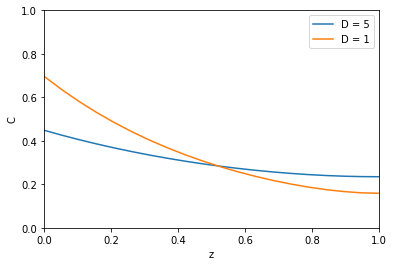

In [9]:
# we are going to use the solve function from the scipy.linalg package
from scipy.linalg import solve

y0 = 1.0

# avoid the fencepost error!
dx = 1./(points-1)
k = 10.
u = 4.
D = 5.

def construct_linear_matrix(u, D, k, y0, points, dx, method = 1):
    # method = 1: central difference
    # method = 2: 1st order upwind
    
    if method != 1:
        A = construct_conv_matrix_upwind(points)
    else:
        A = construct_conv_matrix_central_diff(points)
        
    B = construct_diff_matrix_central_diff(points)
    
    matrix = -u*A/dx + D*B/dx**2
    rates = np.eye(points + 2) * k
    rates[0,0] = 0.0
    rates[-1,-1] = 0.0
    first_row = np.zeros(shape = (points + 2))
    last_row = np.zeros(shape = (points + 2))
    
    if method != 1:
        first_row[0] = 1.
        first_row[1] = dx*u/D - 1.
    else:
        first_row[0] = 1.
        first_row[1] = 2.*dx*u/D
        first_row[2] = -1.
        
    last_row[-3] = -1.
    last_row[-1] = 1.
    matrix = np.vstack((first_row, matrix, last_row))
    matrix = matrix - rates
    # vector on the right hand side of the equation
    rhs = np.zeros(shape = (points + 2))
    
    if method != 1:
        rhs[0] = dx*u/D * y0
    else:
        rhs[0] = 2.*dx*u/D * y0
    
    return matrix, rhs

# Let's plot solutions for two different Ds
k = 10.
u = 4.
D = 5.
matrix, rhs = construct_linear_matrix(u, D, k, y0, points, dx)
C_lin = solve(matrix, rhs)
C_fin = C_lin[1:-1]

k = 10.
u = 4.
D = 1.
matrix, rhs = construct_linear_matrix(u, D, k, y0, points, dx)
C_lin = solve(matrix, rhs)
C_fin_1 = C_lin[1:-1]

# A small function to help plot the results
def plot_profiles(concs, points, legend):
    x = np.linspace(0, 1, num = points)
    for C in concs:
        plt.plot(x, C)
    plt.xlim((0., 1.0))
    plt.ylim((0., 1.0))
    plt.xlabel("z")
    plt.ylabel("C")
    plt.legend(legend)
    
plot_profiles([C_fin, C_fin_1], points, ["D = 5", "D = 1"])

Let's try to compare the error between central difference and upwind difference. We have to go quite coarse on the grid to actually see a difference with these variables.

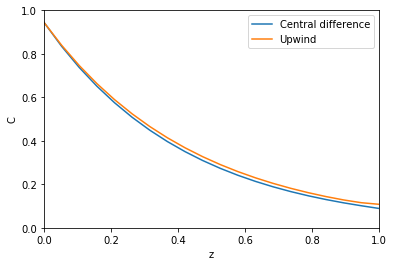

In [11]:
k = 10.
u = 4.
D = 0.1
points = 20
dx = 1/(points - 1)
matrix, rhs = construct_linear_matrix(u, D, k, y0, points, dx)
C_lin = solve(matrix, rhs)
C_central = C_lin[1:-1]

matrix, rhs = construct_linear_matrix(u, D, k, y0, points, dx, 2)
C_lin = solve(matrix, rhs)
C_upwind = C_lin[1:-1]

plot_profiles([C_central, C_upwind], points, ["Central difference", "Upwind"])

If we have a reaction A -> B, we of course need to add the 2nd component to our system and the matrix becomes increasingly sparse.

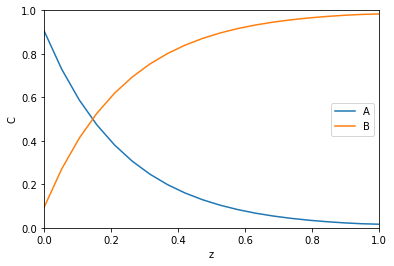

In [13]:
k = 10
y0_A = 1.0
y0_B = 0.0

def construct_convdiff_matrix(u, D, y0, points):
    A = construct_conv_matrix_central_diff(points)
    B = construct_diff_matrix_central_diff(points)
    matrix = -u*A/(2.*dx) + D*B/dx**2
    first_row = np.zeros(shape = (points + 2))
    last_row = np.zeros(shape = (points + 2))
    first_row[0] = 1
    first_row[1] = 2*dx*u/D
    first_row[2] = -1
    last_row[-3] = -1
    last_row[-1] = 1
    matrix = np.vstack((first_row, matrix, last_row))
    # vector on the right hand side of the equation
    rhs = np.zeros(shape = (points + 2))
    rhs[0] = 2*dx*u/D * y0
    return matrix, rhs

def construct_rates_matrix(k, points):
    rates = np.eye(points + 2) * k
    rates[0,0] = 0.0
    rates[-1,-1] = 0.0
    return rates

matrix_A, rhs_A = construct_convdiff_matrix(u, D, y0_A, points)
matrix_B, rhs_B = construct_convdiff_matrix(u, D, y0_B, points)
rates_A = construct_rates_matrix(k, points)
zeros = np.zeros(matrix_A.shape)
matrix_all = np.vstack((np.hstack((matrix_A - rates_A, zeros)), np.hstack((rates_A, matrix_B))))
rhs_all = np.hstack((rhs_A, rhs_B))
C_lin = solve(matrix_all, rhs_all)

C_fin_A = C_lin[1:points+1]
C_fin_B = C_lin[points+3:-1]

plot_profiles([C_fin_A, C_fin_B], points, ["A", "B"])

Now we have seen some linear profiles. Next let's try a nonlinear reaction. Here we use a nonlinear solver the solve the system of equations.

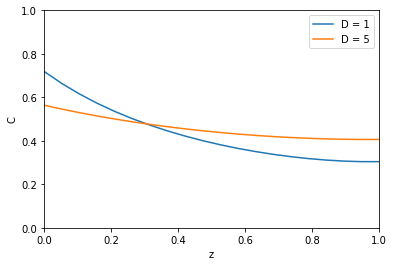

In [17]:
# The nonlinear solver fsolve is imported from scipy.optimize
from scipy.optimize import fsolve

def pfr_discr(y, A, B, dx, k, u, D, y0):
    length = y.shape[0] + 2
    ydot = np.ndarray(shape = (length))
    ydot[1:-1] = y
    ydot[0] = ydot[2] + 2.*dx*u/D*(y0 - ydot[1])
    ydot[-1] = y[-3]
    res = np.dot((-u*A/(2.*dx) + D*B/dx**2), ydot) - k*y**2
    return res

y0 = 1.0
y_init = np.zeros(shape = (points))

dx = 1./(points-1)
k = 10.
u = 4.
D = 1.

A = construct_conv_matrix_central_diff(points)
B = construct_diff_matrix_central_diff(points)

args = (A, B, dx, k, u, D, y0)
C = fsolve(pfr_discr, y_init, args)

D = 5.
args = (A, B, dx, k, u, D, y0)
C2 = fsolve(pfr_discr, y_init, args)

plot_profiles([C, C2], points, ["D = 1", "D = 5"])